In [1]:
import numpy as np
import os
import sys

import torch
from torch import nn
from torchsummary import summary

import importlib

import matplotlib.pyplot as plt

sys.path.insert(0, "../src/")
import data
import model
import train

import nmrglue as ng

np.random.seed(123)

In [2]:
mod = "Ensemble_PIPNet_2021_10_14_lin_noise_multiscale"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}/"

load_model = True

eval_history = False

n_samples = 4

eval_evolution = False

eval_sparse = False

eval_noise = False
noise_levels = [1e-5, 1e-4, 1e-3]

vis_filters = True

eval_exp = False
exp_dir = f"../data/experimental_spectra/topspin/"
exp_compounds = ["ampicillin", "aspala", "flutamide", "histidine", "thymol", "tyrosine"]
exp_range = {"ampicillin": [1500, 2500],
             "aspala": [700, 1300],
             "flutamide": [800, 1300],
             "histidine": [700, 1300],
             "thymol": [800, 1300],
             "tyrosine": [700, 1300],
            }
sel_wrs = [30000., 40000., 50000., 60000., 70000., 80000., 90000.]

data_pars = dict(
                 # General parameters
                 td = 512, # Number of points
                 Fs = 10, # Sampling frequency
                 debug = False, # Print data generation details

                 # Peak parameters
                 pmin = 1, # Minimum number of Gaussians in a peak
                 pmax = 10, # Maximum number of Gaussians in a peak
                 ds = 0.03, # Spread of chemical shift values for each peak
                 lw = [1e-2, 1e-1], # Linewidth range for Gaussians
                 phase = 0., # Spread of phase

                 # Isotropic parameters
                 nmin = 1, # Minimum number of peaks
                 nmax = 10, # Maximum number of peaks
                 shift_range = [1., 9.], # Chemical shift range
                 positive = True, # Force the spectrum to be positive

                 # MAS-dependent parameters
                 mas_g_range = [1e4, 1e5], # MAS-dependent Gaussian broadening range
                 mas_l_range = [1e4, 1e5], # MAS-dependent Lorentzian broadening range
                 mas_s_range = [-1e4, 1e4], # MAS-dependent shift range
                 mas_phase = 0.1, # Random phase range for MAS spectra
                 peakwise_phase = True, # Whether the phase should be peak-wise or spectrum-wise
                 encode_imag = False, # Encode the imaginary part of the MAS spectra
                 nw = 8, # Number of MAS rates
                 mas_w_range = [30000, 100000], # MAS rate range
                 random_mas = False,
                 encode_w = False, # Encode the MAS rate of the spectra

                 # Post-processing parameters
                 noise = 0., # Noise level
                 smooth_end_len = 10, # Smooth ends of spectra
                 scale_iso = 0.8, # Scale isotropic spectra
                 offset = 0., # Baseline offset
                 norm_wr = True, # Normalize MAS rate values
                 wr_inv = False # Encode inverse of MAS rate instead of MAS rate
                )

dataset = data.PIPDataset(**data_pars)

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
def clean_split(l, delimiter):
    """
    Split a line with the desired delimiter, ignoring delimiters present in arrays or strings
    
    Inputs: - l     Input line
    
    Output: - ls    List of sub-strings making up the line
    """
    
    # Initialize sub-strings
    ls = []
    clean_l = ""
    
    # Loop over all line characters
    in_dq = False
    in_sq = False
    arr_depth = 0
    for li in l:
        # Identify strings with double quotes
        if li == "\"":
            if not in_dq:
                in_dq = True
            else:
                in_dq = False
        
        # Identify strings with single quotes
        if li == "\'":
            if not in_sq:
                in_sq = True
            else:
                in_sq = False
        
        # Identify arrays
        if li == "[":
            if not in_sq and not in_dq:
                arr_depth += 1
        if li == "]":
            if not in_sq and not in_dq:
                arr_depth -= 1
        
        # If the delimiter is not within quotes or in an array, split the line at that character
        if li == delimiter and not in_dq and not in_sq and arr_depth == 0:
            ls.append(clean_l)
            clean_l = ""
        else:
            clean_l += li
    
    ls.append(clean_l)
        
    return ls

In [5]:
def get_array(l):
    """
    Get the values in an array contained in a line
    
    Input:  - l         Input line
    
    Output: - vals      Array of values
    """
    
    # Identify empty array
    if l.strip() == "[]":
        return []
    
    # Initialize array
    vals = []
    clean_l = ""
    
    # Loop over all line characters
    arr_depth = 0
    for li in l:
    
        # Identify end of array
        if li == "]":
            arr_depth -= 1
            
            # Check that there are not too many closing brackets for the opening ones
            if arr_depth < 0:
                raise ValueError("Missing \"[\" for matching the number of \"]\"")
        
        # If we are within the array, extract the character
        if arr_depth > 0:
            clean_l += li
    
        # Identify start of array
        if li == "[":
            arr_depth += 1
    
    # Check that the array is properly closed at the end
    if arr_depth > 0:
        raise ValueError("Missing \"]\" for matching the number of \"[\"")
    
    # Extract elements in the array
    ls = clean_split(clean_l, ",")
    
    # Get the value of each element in the array
    for li in ls:
        vals.append(get_val(li.strip()))

    return vals

In [6]:
def get_val(val):
    
    # Remove tailing comma
    if val.endswith(","):
        val = val[:-1]
    
    # Float / Int
    if val.isnumeric():
        
        if "." in val:
            return float(val)
        else:
            return int(val)
    
    # Bool
    if val in ["True", "False"]:
        return bool(val)
    
    # String
    if val.startswith("\""):
        return val.split("\"")[1]
    
    # List
    if val.startswith("["):
        
        return get_array(val)
    
    # Try to return a float anyway
    return float(val)

In [7]:
# Get model architecture
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

model_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "model_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        key, val = L.split("=")
        
        v = get_val(val.strip())
        
        model_pars[key.strip()] = v

model_pars["noise"] = 0.

In [8]:
# Load loss and learning rate
all_lrs = np.load(in_dir + "all_lrs.npy")
all_losses = np.load(in_dir + "all_losses.npy")
all_val_losses = np.load(in_dir + "all_val_losses.npy")

n_chk = all_losses.shape[0]
best_chk = np.argmin(np.mean(all_val_losses, axis=1))
print(best_chk)

98


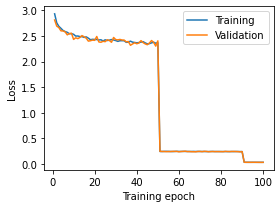

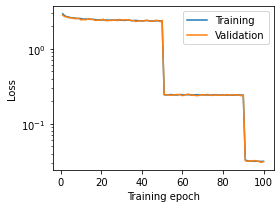

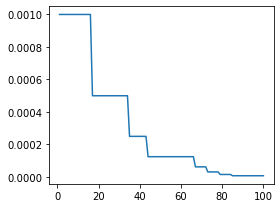

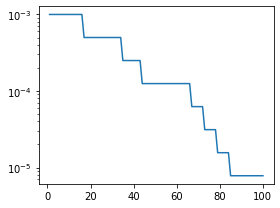

In [9]:
# Plot loss
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_losses, axis=1))
ax.plot(range(1, n_chk+1), np.mean(all_val_losses, axis=1))

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss.pdf")

plt.show()
plt.close()

# Plot loss, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_losses, axis=1))
ax.semilogy(range(1, n_chk+1), np.mean(all_val_losses, axis=1))

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss_log.pdf")

plt.show()
plt.close()

# Plot learning rate
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs.pdf")

plt.show()
plt.close()

# Plot learning rate, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs_log.pdf")

plt.show()
plt.close()

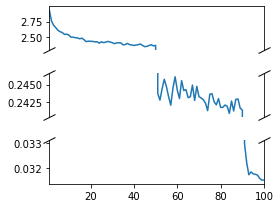

In [10]:
d = 0.5

mean_losses = np.mean(all_losses, axis=1)
mean_losses_dif = np.abs(mean_losses[1:] - mean_losses[:-1])
rel_diffs = mean_losses_dif / mean_losses[:-1]
jumps = np.where(rel_diffs > 0.3)[0]+1

fig = plt.figure(figsize=(4,3))

axs = []
for i in range(len(jumps) + 1):
    axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))
    
    # Plot broken axes markers
    if i > 0:
        axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                    markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)
        
        axs[i].spines["top"].set_visible(False)
        
    if i < len(jumps):
        axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                    markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)
        
        axs[i].spines["bottom"].set_visible(False)
        axs[i].set_xticks([])
    
    axs[i].plot(range(1, n_chk+1), mean_losses)
    axs[i].set_xlim(1, n_chk)
    
    if i == 0:
        M = np.max(mean_losses[:jumps[i]])
        m = np.min(mean_losses[:jumps[i]])
        
    elif i == len(jumps):
        M = np.max(mean_losses[jumps[i-1]:])
        m = np.min(mean_losses[jumps[i-1]:])
    
    else:
        M = np.max(mean_losses[jumps[i-1]:jumps[i]])
        m = np.min(mean_losses[jumps[i-1]:jumps[i]])
    
    r = M - m
    
    axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)
    
fig.tight_layout()

plt.savefig(fig_dir + "lrs_split.pdf")

# Evaluate the model history

In [11]:
if eval_history:

    fdir = fig_dir + "eval_history/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):

        d = fdir + f"checkpoint_{i+1}/"
        if not os.path.exists(d):
            os.mkdir(d)

        X = np.load(in_dir + f"checkpoint_{i+1}_in.npy")
        y_trg = np.load(in_dir + f"checkpoint_{i+1}_trg.npy")
        y_pred = np.load(in_dir + f"checkpoint_{i+1}_pred.npy")
        y_std = np.load(in_dir + f"checkpoint_{i+1}_std.npy")

        plot_checkpoint(X, y_trg, y_pred, y_std, show=False, save=d)
        
        break

print("All done!")

All done!


# Load model and generate dataset

In [12]:
if eval_evolution or eval_sparse or eval_noise or eval_exp or vis_filters:

    net = model.ConvLSTMEnsemble(**model_pars)
    
    if eval_evolution or eval_sparse or eval_noise or vis_filters:

        X = []
        y = []

        for i in range(n_samples):
            Xi, _, yi = dataset.__getitem__(0)
            X.append(Xi.unsqueeze(0))
            y.append(yi.unsqueeze(0))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)

In [13]:
X.shape

torch.Size([4, 8, 1, 512])

In [14]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [33]:
h, c = net.models[0]._init_hidden(batch_size=X.shape[0],image_size=X.shape[-1])[0]
X1 = net.models[0]._batch_input(X)

all_h = []
all_c = []
all_x = []
all_i = []
all_f = []
all_o = []
all_g = []

for ind in range(X1.shape[1]):
    i, f, o, g, h2, c2 = net.models[0].cell_list[0].analyze(X1[:, ind], [h, c])
    
    all_h.append(h.clone())
    all_c.append(c.clone())
    all_x.append(X1[:, ind].clone())
    all_i.append(i.detach().clone())
    all_f.append(f.detach().clone())
    all_o.append(o.detach().clone())
    all_g.append(g.detach().clone())
    
    h = h2.detach().clone()
    c = c2.detach().clone()

In [69]:
n_filt = all_h[0].shape[1] + 1
n_row = int(np.sqrt(n_filt))
n_col = int(n_filt / n_row)

print(n_filt, n_row, n_col)

64 8 8


8 8


TypeError: missing a required argument: 'y'

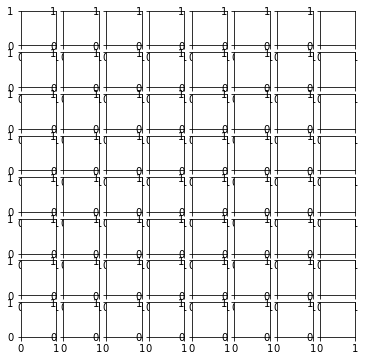

In [54]:
n_filt = all_h[0].shape[1]
n_row = int(np.sqrt(n_filt))
n_col = int(n_filt / n_row)

print(n_row, n_col)

for h, c, x, i, f, o, g in zip(all_h, all_c, all_x, all_i, all_f, all_o, all_g):
    
    for sample in range(h.shape[0]):
        
        fig = plt.figure(figsize=(6,6))
        axs = []
        for row in range(n_row):
            for col in range(n_col):
                axs.append(fig.add_subplot(n_row,n_col,(row * n_col) + col + 1))
        
        for filt in range(h.shape[1]):
            axs[filt].scatter(range(x.shape[-1]))
            a = 0
            
        plt.show()
        plt.close()
            
        break
    
    break

In [28]:
h.shape

torch.Size([4, 64, 512])

In [129]:
X1.shape

torch.Size([4, 5, 4, 512])

In [130]:
x = torch.cat([X1[:, 0], h0], dim=1)

In [131]:
x.shape

torch.Size([4, 68, 512])

In [138]:
h1, c1 = net.models[-1].cell_list[0].forward(X1[:, 0], [h, c])

In [172]:
combined = torch.cat([X1[:, 0], h0], dim=1)  # concatenate along channel axis

combined_conv = net.models[-3].cell_list[0].conv.forward(x)
cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, net.models[0].cell_list[0].hidden_dim, dim=1)
i = torch.sigmoid(cc_i)
f = torch.sigmoid(cc_f)
o = torch.sigmoid(cc_o)
g = torch.tanh(cc_g)

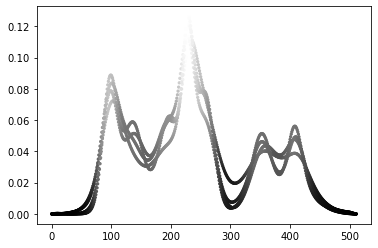

In [198]:
ind = 53
for xi in X1[0, 0]:
#    plt.scatter(h)
    plt.scatter(range(xi.shape[0]), xi, s=5, c=i[0, ind].detach(), cmap="Greys")

In [30]:
filters = 
filters = torch.nn.Sigmoid(filters)

TypeError: __init__() takes 1 positional argument but 2 were given

In [27]:
filters

tensor([[[ 0.0744,  0.0744,  0.0744,  ...,  0.0744,  0.0744,  0.0744],
         [ 0.0937,  0.0937,  0.0937,  ...,  0.0937,  0.0937,  0.0937],
         [-0.0042, -0.0041, -0.0041,  ..., -0.0041, -0.0041, -0.0042],
         ...,
         [-0.0357, -0.0357, -0.0357,  ..., -0.0357, -0.0357, -0.0357],
         [ 0.0232,  0.0232,  0.0232,  ...,  0.0232,  0.0232,  0.0232],
         [-0.0667, -0.0667, -0.0667,  ..., -0.0667, -0.0667, -0.0667]],

        [[ 0.0744,  0.0744,  0.0744,  ...,  0.0744,  0.0744,  0.0744],
         [ 0.0937,  0.0937,  0.0937,  ...,  0.0937,  0.0937,  0.0937],
         [-0.0042, -0.0041, -0.0041,  ..., -0.0041, -0.0041, -0.0042],
         ...,
         [-0.0357, -0.0357, -0.0357,  ..., -0.0357, -0.0357, -0.0357],
         [ 0.0232,  0.0232,  0.0232,  ...,  0.0232,  0.0232,  0.0232],
         [-0.0667, -0.0667, -0.0667,  ..., -0.0667, -0.0667, -0.0667]],

        [[ 0.0744,  0.0744,  0.0745,  ...,  0.0745,  0.0744,  0.0744],
         [ 0.0937,  0.0937,  0.0937,  ...,  0

In [206]:
h, c = net.models[0].cell_list[0].forward(X[:, :4].reshape(4, 4, 512), X0)

In [210]:
h2, c2 = net.models[0].cell_list[0].forward(X[:, -4:].reshape(4, 4, 512), X0)

In [207]:
h.shape

torch.Size([4, 64, 512])

In [208]:
h.shape

torch.Size([4, 64, 512])

In [253]:
i = 0

In [257]:
colors = np.ones((X.shape[-1], 3)) * h[0, i].detach().numpy()[:, np.newaxis]

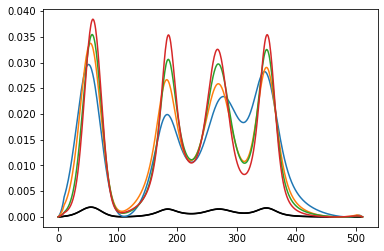

In [252]:
plt.plot(X[0, :4, 0].T)


plt.scatter(range(X.shape[-1]), h[0, i].detach() - torch.min(h[0,i].detach()), c=colors, s=0.5)

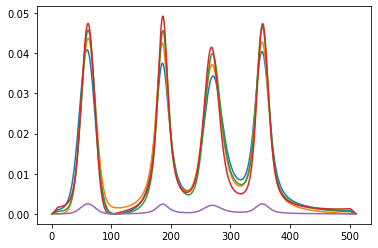

In [233]:
plt.plot(X[0, -4:, 0].T)
plt.plot(h2[0, i].detach() - torch.min(h2[0,i].detach()))

In [197]:
h[0, :3]

tensor([[-0.0292, -0.0291, -0.0291,  ..., -0.0291, -0.0292, -0.0292],
        [ 0.0049,  0.0049,  0.0049,  ...,  0.0049,  0.0049,  0.0049],
        [ 0.0046,  0.0046,  0.0046,  ...,  0.0046,  0.0046,  0.0046]],
       grad_fn=<SliceBackward>)

In [201]:
plt.plot(X[0, 0, 0].detach(), c=h[0, :3].detach().numpy().T - torch.min(h[0,:3].detach(), axis=1)[0].numpy())

ValueError: Invalid RGBA argument: array([[0.0000000e+00, 1.3549244e-03, 0.0000000e+00],
       [3.0454248e-06, 1.3492773e-03, 5.6130812e-06],
       [6.7390501e-06, 1.3424410e-03, 1.2431759e-05],
       ...,
       [4.0065497e-06, 1.3474184e-03, 7.4072741e-06],
       [2.2295862e-06, 1.3507628e-03, 4.1141175e-06],
       [0.0000000e+00, 1.3549244e-03, 0.0000000e+00]], dtype=float32)

<Figure size 432x288 with 1 Axes>

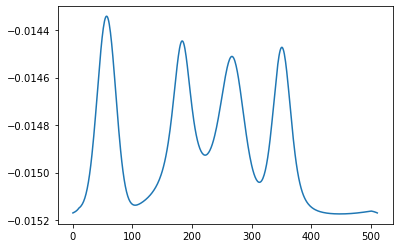

In [173]:
plt.plot(h[0, 3].detach())

In [161]:
output[0], output[1] 

(tensor([[[-0.0292, -0.0291, -0.0291,  ..., -0.0291, -0.0292, -0.0292],
          [ 0.0049,  0.0049,  0.0049,  ...,  0.0049,  0.0049,  0.0049],
          [ 0.0046,  0.0046,  0.0046,  ...,  0.0046,  0.0046,  0.0046],
          ...,
          [-0.0203, -0.0203, -0.0203,  ..., -0.0203, -0.0203, -0.0203],
          [ 0.0069,  0.0069,  0.0069,  ...,  0.0069,  0.0069,  0.0069],
          [-0.0175, -0.0175, -0.0175,  ..., -0.0175, -0.0175, -0.0175]],
 
         [[-0.0292, -0.0292, -0.0292,  ..., -0.0292, -0.0292, -0.0292],
          [ 0.0049,  0.0049,  0.0049,  ...,  0.0049,  0.0049,  0.0049],
          [ 0.0046,  0.0046,  0.0046,  ...,  0.0046,  0.0046,  0.0046],
          ...,
          [-0.0203, -0.0203, -0.0203,  ..., -0.0203, -0.0203, -0.0203],
          [ 0.0069,  0.0069,  0.0069,  ...,  0.0069,  0.0069,  0.0069],
          [-0.0175, -0.0175, -0.0175,  ..., -0.0175, -0.0175, -0.0175]],
 
         [[-0.0292, -0.0291, -0.0291,  ..., -0.0291, -0.0291, -0.0292],
          [ 0.0049,  0.0048,

In [78]:
def plot_checkpoint(X, y_trg, y_pred, y_std, ys=None, input_factor=0.5, show=True, save=None,
                    c_start=[0., 1., 1.], c_stop=[0., -1., 0.], c2_start=[1., 1., 0.], c2_stop=[0., -1., 0.]):
    
    if y_std is None:
        y_std = [[] for _ in range(X.shape[0])]
    
    n_pts = X.shape[-1]
    
    n = X.shape[1] - 1
    
    colors = [[c0 + (i / n) * c1 for c0, c1 in zip(c_start, c_stop)] for i in range(n+1)]
    
    if ys is not None:
        n2 = ys.shape[0] - 1
        colors2 = [[c0 + (i / n2) * c1 for c0, c1 in zip(c2_start, c2_stop)] for i in range(n2+1)]
    
    for i, (Xi, yi_trg, yi_pred, yi_std) in enumerate(zip(X, y_trg, y_pred, y_std)):
    
        # Print target vs. pred
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(yi_trg[0], linewidth=1.)
        ax.plot(yi_pred[0], linewidth=1.)
        
        if len(yi_std) > 0:
            ax.fill_between(range(n_pts), yi_pred[0] - yi_std[0], yi_pred[0] + yi_std[0], facecolor="C1", alpha=0.3)
        
        ax.legend(["Ground-truth", "Prediction"])
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_pred.pdf")
            
        plt.close()
        
        if ys is not None:
            # Print target vs. all preds
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            h1 = ax.plot(yi_trg[0], linewidth=1.)
            
            for c, yi in zip(colors2, ys[:, i, 0, :]):
                ax.plot(yi, linewidth=1., color=c)
                
            h2 = ax.plot(yi_pred[0], linewidth=1., color="k")
            
            ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"])

            if show:
                plt.show()

            if save is not None:
                plt.savefig(save + f"sample_{i+1}_all_preds.pdf")

            plt.close()
            
            for j in range(ys.shape[0]):
                # Print target vs. all preds
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                h1 = ax.plot(yi_trg[0], linewidth=1.)
                
                ax.plot(ys[j, i, 0, :], linewidth=1., color=colors2[j])

                h2 = ax.plot(yi_pred[0], linewidth=1., color="k")

                ax.legend([h1[0], h2[0]], ["Ground-truth", "Prediction"])

                if show:
                    plt.show()

                if save is not None:
                    plt.savefig(save + f"sample_{i+1}_pred_{j+1}.pdf")

                plt.close()
        
        # Print input and target
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        for x, c in zip(Xi[:, 0, :], colors):
            ax.plot(x / np.max(Xi[:, 0, :]), linewidth=1., color=c)
        ax.plot(yi_trg[0] / np.max(yi_trg[0]) * input_factor, "r", linewidth=1.)
        
        if show:
            plt.show()
            
        if save is not None:
            plt.savefig(save + f"sample_{i+1}_input.pdf")
            
        plt.close()
    
    return

In [79]:
sel_chk = [0, 1, 98]

In [80]:
if eval_evolution:

    fdir = fig_dir + "eval_evolution/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        if i in sel_chk:

            print(f"Checkpoint {i+1}/{n_chk}...")

            d = fdir + f"checkpoint_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)

            print("  Loading model...")
            net.load_state_dict(torch.load(in_dir + f"checkpoint_{i+1}_network", map_location=torch.device("cpu")))
            net.eval()

            print("  Performing predictions...")
            y_pred, y_std, ys = net(X)
            y_pred = y_pred.detach().numpy()
            y_std = y_std.detach().numpy()
            ys = ys.detach().numpy()

            print("  Plotting data...")
            plot_checkpoint(X.numpy(), y.numpy(), y_pred, y_std, ys=ys, show=False, save=d)
        
print("All done!")

Checkpoint 1/100...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 2/100...
  Loading model...
  Performing predictions...
  Plotting data...
Checkpoint 99/100...
  Loading model...
  Performing predictions...
  Plotting data...
All done!


In [12]:
if eval_sparse:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_sparse/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    # Lower MAS inputs
    print("Lower MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"lower_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, :i])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
    
    # Higher MAS inputs
    print("Higher MAS range...")
    for i in range(model_pars["batch_input"], X.shape[1]+1):
        
        d = fdir + f"higher_{i}_rates/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X[:, -i:])
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X, y, y_std, y_pred, show=False, save=d)
        
print("All done!")

Lower MAS range...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
Higher MAS range...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
  Performing predictions...
  Plotting data...
All done!


In [13]:
if eval_noise:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))

    fdir = fig_dir + "eval_noise/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)
    
    for noise in noise_levels:
        
        break
        
        print(f"Noise level {noise:.0e}...")
        
        d = fdir + f"noise_level_{noise:.0e}/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        # Generate noisy data
        X2 = X.clone() + (torch.randn(X.shape) * noise)
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_std, y_pred, show=False, save=d)
        
        print("Normalizing noisy spectra...")
        
        d = fdir + f"noise_level_{noise:.0e}_norm/"
        if not os.path.exists(d):
            os.mkdir(d)
        
        vals_min, _ = torch.min(X2[:, :, 0], dim=-1)
        vals_min = torch.unsqueeze(vals_min, -1)
        X2[:, :, 0] -= vals_min
        
        print("  Performing predictions...")
        y_pred, y_std, _ = net(X2)
        y_pred = y_pred.detach().numpy()
        y_std = y_std.detach().numpy()
        
        print("  Plotting data...")
        plot_checkpoint(X2, y, y_std, y_pred, show=False, save=d)
    
print("All done!")

All done!


# Evaluate experimental data

In [81]:
def load_topspin_spectrum(d):
    
    pd = f"{d}pdata/1/"
    
    fr = pd + "1r"
    fi = pd + "1i"
    
    try:

        with open(fr, "rb") as F:
            dr = np.fromfile(F, np.int32).astype(float)

        with open(fi, "rb") as F:
            di = np.fromfile(F, np.int32).astype(float)
        
        with open(f"{d}acqus", "r") as F:
            lines = F.read().split("\n")
        
        for l in lines:
            if l.startswith("##$MASR"):
                wr = float(l.split("=")[1].strip())

    except:
        dr = np.array([])
        di = np.array([])
        wr = -1
    
    return dr, di, wr

In [86]:
def plot_exp(X, y_pred, y_std, ys=None, y_trg=None, input_factor=0.5, show=True, save=None,
             c_start=[0., 1., 1.], c_stop=[0., -1., 0.], c2_start=[1., 1., 0.], c2_stop=[0., -1., 0.]):
    
    n_pts = X.shape[-1]
    n = X.shape[1] - 1
    
    colors = [[c0 + (i / n) * c1 for c0, c1 in zip(c_start, c_stop)] for i in range(n+1)]
    
    if ys is not None:
        n2 = ys.shape[0] - 1
        colors2 = [[c0 + (i / n2) * c1 for c0, c1 in zip(c2_start, c2_stop)] for i in range(n2+1)]
    
    if y_trg is not None:
        
        # Print target vs. pred
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)

        ax.plot(y_trg[0, 0], linewidth=0.5)
        ax.plot(y_pred[0, 0], linewidth=0.5)

        if len(y_std[0]) > 0:
            ax.fill_between(range(n_pts), y_pred[0, 0] - y_std[0, 0], y_pred[0, 0] + y_std[0, 0], facecolor="C1", alpha=0.3)

        ax.legend(["Ground-truth", "Prediction"])

        if show:
            plt.show()

        if save is not None:
            plt.savefig(save + "_gt_vs_pred.pdf")

        plt.close()

        # Print input and target
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        for c, x in zip(colors, X[0, :, 0, :]):
            ax.plot(x / np.max(x), linewidth=0.5, color=c)
            
        ax.plot(y_trg[0, 0] / np.max(y_trg[0, 0]) * input_factor, "r", linewidth=0.5)

        if show:
            plt.show()

        if save is not None:
            plt.savefig(save + "_X_vs_gt.pdf")

        plt.close()
    
    # Print input and pred
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    for c, x in zip(colors, X[0, :, 0, :]):
            ax.plot(x / np.max(x), linewidth=0.5, color=c)
    
    ax.plot(y_pred[0, 0] / np.max(y_pred[0, 0]) * input_factor, "r", linewidth=0.5)

    if len(y_std[0]) > 0:
        ax.fill_between(range(n_pts), y_pred[0, 0] - y_std[0, 0], y_pred[0, 0] + y_std[0, 0], facecolor="C1", alpha=0.3)

    if show:
        plt.show()

    if save is not None:
        plt.savefig(save + "_X_vs_pred.pdf")

    plt.close()
    
    if ys is not None:
        # Print input and pred
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)

        for c, x in zip(colors, X[0, :, 0, :]):
            ax.plot(x / np.max(x), linewidth=0.5, color=c)
        
        for c, y in zip(colors2, ys[:, 0, 0, :]):
            ax.plot(y / np.max(y) * input_factor, linewidth=0.5, color=c)

        ax.plot(y_pred[0, 0] / np.max(y_pred[0, 0]) * input_factor, "k", linewidth=0.5)

        if show:
            plt.show()

        if save is not None:
            plt.savefig(save + "_X_vs_all_preds.pdf")

        plt.close()
        
        for j in range(ys.shape[0]):
            # Print input and pred
            fig = plt.figure(figsize=(4,3))
            ax = fig.add_subplot(1,1,1)

            for c, x in zip(colors, X[0, :, 0, :]):
                ax.plot(x / np.max(x), linewidth=0.5, color=c)

            ax.plot(ys[j, 0, 0, :] / np.max(y) * input_factor, linewidth=0.5, color=colors2[j])

            ax.plot(y_pred[0, 0] / np.max(y_pred[0, 0]) * input_factor, "k", linewidth=0.5)

            if show:
                plt.show()

            if save is not None:
                plt.savefig(save + f"_X_vs_pred_{j+1}.pdf")

            plt.close()
    
    return

In [87]:
if eval_exp:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
    
    fdir = fig_dir + "eval_exp/"
    if not os.path.exists(fdir):
        os.mkdir(fdir)

    exp_mas = []
    exp_wrs = []
    exp_trg = []

    for compound in exp_compounds:

        comp_mas = []
        comp_wrs = []

        d = f"{exp_dir}{compound}/"

        i0 = -1
        n_exp = 0
        ds = os.listdir(d)
        for di in ds:
            if os.path.isdir(d + di):
                i = int(di)
                n_exp = max(n_exp, i)

                if i0 == -1 or i < i0:
                    i0 = i

        l = -1

        for i in range(i0, n_exp):
            Xr, Xi, wr = load_topspin_spectrum(f"{d}{i+1}/")

            if l == -1 and Xr.shape[0] > 0:
                l = Xr.shape[0]

            if Xr.shape[0] == l:
                comp_mas.append(Xr)
                comp_wrs.append(wr)

        # Normalize spectra
        comp_mas = np.array(comp_mas)
        comp_mas /= np.mean(comp_mas, axis=1)[:, np.newaxis]
        M = np.max(comp_mas)
        comp_mas *= 0.25 / M

        # Sort by MAS rate
        inds = np.argsort(comp_wrs)

        exp_mas.append(np.array(comp_mas)[inds])
        exp_wrs.append(np.array(comp_wrs)[inds])
    
    Xs = []

    for comp, exp in zip(exp_compounds, exp_mas):
        x = torch.Tensor(exp[:, exp_range[comp][0]:exp_range[comp][1]])

        x = torch.unsqueeze(x, 0)
        x = torch.unsqueeze(x, 2)
        Xs.append(x)
    
    for i, compound in enumerate(exp_compounds):
    
        wr_inds = []

        for wr in sel_wrs:
            wr_inds.append(np.argmin(np.abs(exp_wrs[i] - wr)))

        X = Xs[i][:, wr_inds, :, :]

        y_pred, y_std, ys = net(X)

        plot_exp(Xs[i].numpy(), y_pred.detach().numpy(), y_std.detach().numpy(), ys=ys.detach().numpy(), show=False, save=f"{fdir}{compound}")

print("All done!")

All done!


In [88]:
model_pars

{'n_models': 15,
 'input_dim': 1,
 'hidden_dim': 64,
 'kernel_size': [[1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1],
  [3, 3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3, 3],
  [3, 3, 3, 3, 3, 3],
  [5, 5, 5, 5, 5, 5],
  [5, 5, 5, 5, 5, 5],
  [5, 5, 5, 5, 5, 5],
  [7, 7, 7, 7, 7, 7],
  [7, 7, 7, 7, 7, 7],
  [7, 7, 7, 7, 7, 7],
  [9, 9, 9, 9, 9, 9],
  [9, 9, 9, 9, 9, 9],
  [9, 9, 9, 9, 9, 9]],
 'num_layers': 6,
 'final_kernel_size': [1, 5, 9, 1, 5, 9, 1, 5, 9, 1, 5, 9, 1, 5, 9],
 'batch_input': 4,
 'bias': True,
 'final_bias': True,
 'return_all_layers': True,
 'final_act': 'linear',
 'noise': 0.0}